# Notebook to plot results from deblurring

[INFO] Found 93 metrics files for Pretrained (Image+CLIP) under /midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_autumn_sweep_27/preds
[INFO] Found 68 metrics files for Pretrained (Image only) under /midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_expert_sweep_31/preds
[INFO] Found 28 metrics files for Random init under /midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_random/preds


,series,subtype,ntr,metric,csv_path
0,Pretrained (Image+CLIP),cell_nucleus_patches,8,27.55220,/midtier/paetzollab/scratch/ads4015/temp_selma...
1,Pretrained (Image+CLIP),cell_nucleus_patches,9,28.07665,/midtier/paetzollab/scratch/ads4015/temp_selma...
2,Pretrained (Image+CLIP),cell_nucleus_patches,10,28.55240,/midtier/paetzollab/scratch/ads4015/temp_selma...
3,Pretrained (Image+CLIP),cell_nucleus_patches,10,28.26945,/midtier/paetzollab/scratch/ads4015/temp_selma...
4,Pretrained (Image+CLIP),cell_nucleus_patches,1,22.94380,/midtier/paetzollab/scratch/ads4015/temp_selma...


[INFO] Loaded 189 runs total.
[INFO] Subtypes: ['cell_nucleus_patches', 'vessels_patches']


/tmp/ipykernel_3357110/262583706.py:126: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Series")


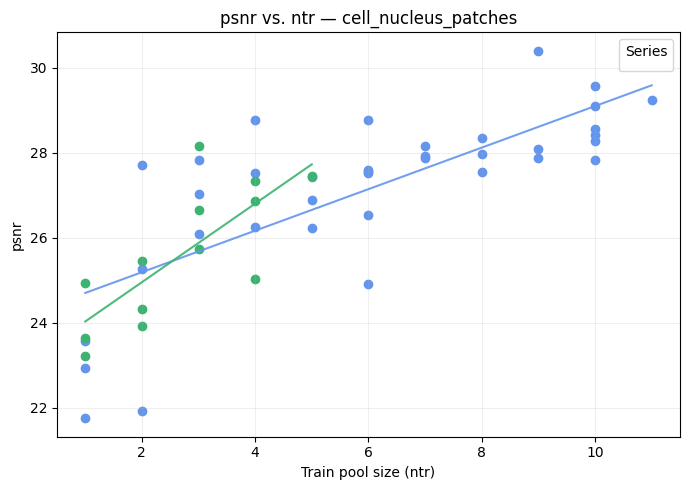

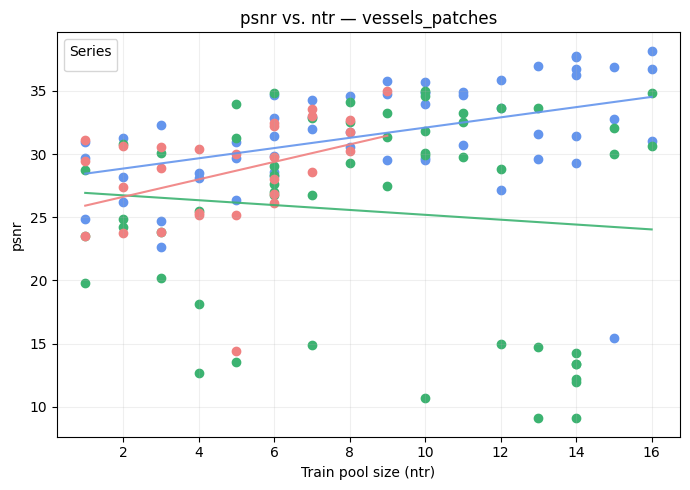

In [ ]:
# imports
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. Configs
# --------------------------------------------------
RESULT_SETS = [
    ("Pretrained (Image+CLIP)", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_autumn_sweep_27/preds"),
    ("Pretrained (Image only)", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_expert_sweep_31/preds"),
    ("Random init",            "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_random/preds"),
]

METRIC_COL = "psnr"

COLOR_MAP = {
    "Pretrained (Image+CLIP)": "cornflowerblue",
    "Pretrained (Image only)": "mediumseagreen",
    "Random init": "lightcoral",
}

# --------------------------------------------------
# 2. Collect data from all metrics_test.csv files
# --------------------------------------------------
rows = []

for label, root in RESULT_SETS:
    root = Path(root)
    if not root.exists():
        print(f"[WARN] Root does not exist, skipping: {root}")
        continue

    csv_paths = sorted(root.rglob("metrics_test.csv"))
    if not csv_paths:
        print(f"[WARN] No metrics_test.csv found under {root}")
        continue

    print(f"[INFO] Found {len(csv_paths)} metrics files for {label} under {root}")

    for csv_path in csv_paths:
        # parse ntr from folder name: .../fttr19_.../preds/metrics_test.csv
        m = re.search(r"fttr(\d+)", str(csv_path))
        if m:
            ntr = int(m.group(1))
        else:
            m2 = re.search(r"trlim(\d+)", str(csv_path))
            ntr = int(m2.group(1)) if m2 else None

        if ntr is None:
            print(f"[WARN] Could not parse ntr from path: {csv_path}")
            continue

        df = pd.read_csv(csv_path)

        if METRIC_COL not in df.columns:
            print(f"[WARN] {METRIC_COL} not in {csv_path}, has columns {df.columns.tolist()}")
            continue

        # get subtype from CSV if available, else from path
        if "subtype" in df.columns:
            subtype = str(df["subtype"].iloc[0])
        else:
            # path pattern: .../preds/<subtype>/<tag>/preds/metrics_test.csv
            parts = csv_path.parts
            try:
                idx = parts.index("preds")
                subtype = parts[idx + 1]
            except ValueError:
                subtype = "unknown"

        metric_mean = float(df[METRIC_COL].astype(float).mean())

        rows.append(
            {
                "series": label,
                "subtype": subtype,
                "ntr": ntr,
                "metric": metric_mean,
                "csv_path": str(csv_path),
            }
        )

data = pd.DataFrame(rows)
display(data.head())
print(f"[INFO] Loaded {len(data)} runs total.")
print("[INFO] Subtypes:", sorted(data["subtype"].unique()))

# --------------------------------------------------
# 3. Plot: one figure per subtype (datatype)
# --------------------------------------------------
for subtype in sorted(data["subtype"].unique()):
    sub_df = data[data["subtype"] == subtype]

    if sub_df.empty:
        continue

    plt.figure(figsize=(7, 5))

    for label in sub_df["series"].unique():
        df_series = sub_df[sub_df["series"] == label]

        # scatter points
        plt.scatter(
            df_series["ntr"], df_series["metric"],
            color=COLOR_MAP.get(label, None)
            )

        # best-fit line if we have >= 2 points
        x = df_series["ntr"].values
        y = df_series["metric"].values
        if len(df_series) >= 2:
            coeffs = np.polyfit(x, y, deg=1)
            xs = np.linspace(x.min(), x.max(), 100)
            ys = np.polyval(coeffs, xs)
            plt.plot(xs, ys, alpha=0.9, color=COLOR_MAP.get(label, None))

    plt.xlabel("Train pool size (ntr)")
    plt.ylabel(METRIC_COL)
    plt.title(f"{METRIC_COL} vs. ntr — {subtype}")
    plt.legend(title="Series")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()
